In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

#from tabulate import tabulate
from time import time

import pystan
from pystan import StanModel

import statsmodels.api as sm
import statsmodels.formula.api as smf

### data

In [2]:
data = pd.read_csv("./data.csv")
col_name = data.columns

In [3]:
# data preparation
Y = np.hstack([data["1st mean"], data["2nd mean"]])
Age = np.hstack([np.zeros(10), np.ones(10)])
X = np.hstack([data["Type"], data["Type"]])
X = np.hstack([X.reshape(-1,1), Age.reshape(-1,1)])
X = pd.DataFrame(X)

### model1

In [4]:
# data preparationfor model1
data_model1 = pd.concat([X,pd.DataFrame(Y)], axis=1)
data_model1.columns = ["Type", "Age", "meanY"]

In [5]:
formula = "meanY ~  1 + Age + Age:Type"
link = sm.genmod.families.links.identity
family = sm.families.Gaussian(link=link)

mod = smf.glm(formula=formula, data=data_model1, family=family )
result = mod.fit() 
print(result.summary())

print(result.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  meanY   No. Observations:                   20
Model:                            GLM   Df Residuals:                       17
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          1.5827
Method:                          IRLS   Log-Likelihood:                -31.345
Date:                Sun, 28 Jun 2020   Deviance:                       26.907
Time:                        22:14:27   Pearson chi2:                     26.9
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    152.9050      0.398    384.341      0.0

C:\Users\yoshi\Miniconda3\envs\stan\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  This is separate from the ipykernel package so we can avoid doing imports until


### Bayes model1

In [6]:
X = data_model1.iloc[:,:2]
y = data_model1.iloc[:,-1]

In [7]:
dat = {'N': X.shape[0], 'M': X.shape[1], 'X': X, 'y': y}

In [8]:
stan_model = """
data {
    int<lower=0> N;
    int<lower=0> M;
    matrix[N,M] X;
    real y[N];
}

parameters {
    real beta1;
    real beta2;
    real beta3;
    real<lower=0> sigma;
}

model{
    for (n in 1:N){
      y[n] ~ normal(beta1 + beta2 * X[n,2] + beta3*X[n,1]*X[n,2], sigma);
    }
    beta1 ~ uniform(-1e+4, 1e+4);
    beta2 ~ uniform(-1e+4, 1e+4);
    beta3 ~ uniform(-1e+4, 1e+4);
    sigma ~ uniform(-1e+4, 1e+4);
}
 
"""

In [9]:
# Build Stan model
%time stm = StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_433ba1d713981081b1bc4b0f8c03d857 NOW.


Wall time: 35.8 s


In [10]:
n_itr = 3000
n_warmup = 200
chains = 2

# サンプリングの実行
fit_model1 = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
print(fit_model1)

Inference for Stan model: anon_model_433ba1d713981081b1bc4b0f8c03d857.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1 152.91  8.2e-3   0.43 152.06 152.64 152.91 153.18 153.76   2786    1.0
beta2   5.64    0.01   0.75    4.1   5.16   5.65   6.14    7.1   2579    1.0
beta3  -1.71    0.01   0.88  -3.46   -2.3  -1.72  -1.15   0.07   3701    1.0
sigma   1.36  4.6e-3   0.26   0.96   1.18   1.33   1.51   1.96   3232    1.0
lp__  -15.05    0.04    1.6  -18.9 -15.82  -14.7 -13.89 -13.08   1859    1.0

Samples were drawn using NUTS at Sun Jun 28 22:15:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


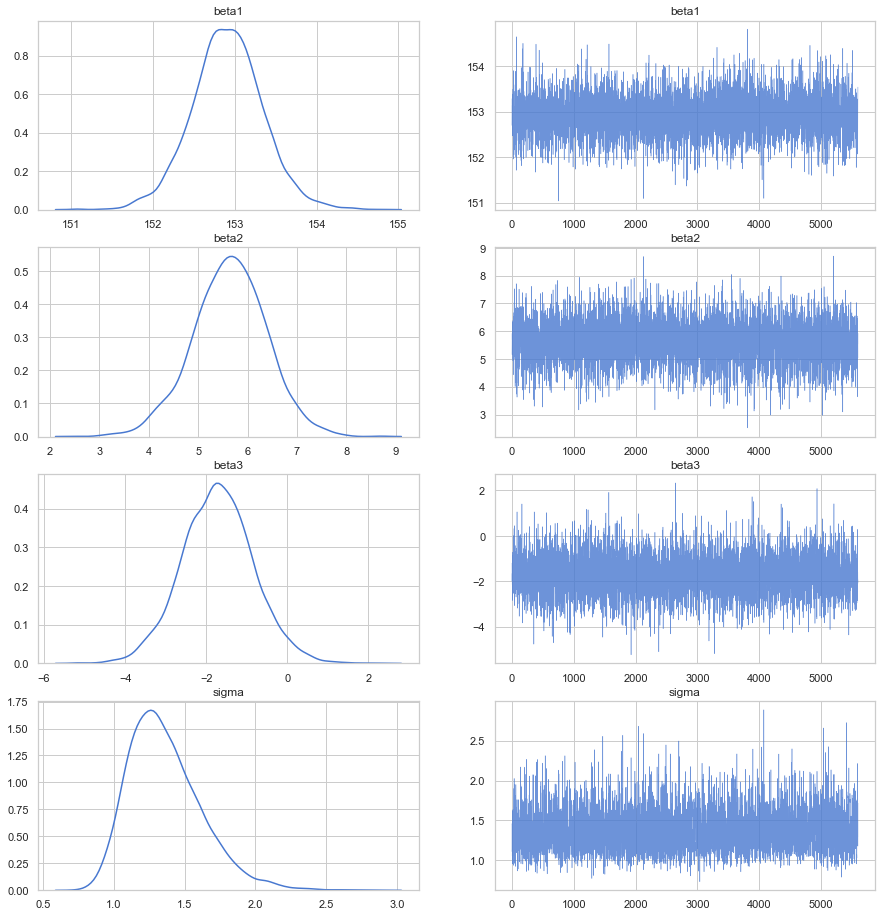

In [11]:
la  = fit_model1.extract(permuted=True) #extract results
names = fit_model1.model_pars #get  parameters names
n_param = np.sum([1 if len(x) == 0 else np.prod(x) for x in fit_model1.par_dims])
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt=0
for name in names:
    temp_data = la[name]
    #r, mu
    if temp_data.ndim == 3:
        for i in range(temp_data.shape[1]):
            for j in range(temp_data.shape[2]):
                d = temp_data[:,i,j]
                sns.distplot(d, hist=False, ax=axes[cnt, 0])
                x = np.linspace(0, len(d)-1, len(d))
                sns.lineplot(x,d,alpha=0.8, lw=.5, ax=axes[cnt, 1])
                cnt += 1
    #s
    elif temp_data.ndim == 2:
        for i in range(temp_data.shape[1]):
            d = temp_data[:,i]
            sns.distplot(d, hist=False, ax=axes[cnt, 0])
            x = np.linspace(0, len(d)-1, len(d))
            sns.lineplot(x,d,alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    #Intercept
    else:
        sns.distplot(temp_data, hist=False, ax=axes[cnt, 0])
        x = np.linspace(0, len(temp_data)-1, len(temp_data))
        sns.lineplot(x, temp_data,alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1
        
name_list = []
for name in names:
    temp_data = la[name]
    if temp_data.ndim == 3:
        for i in range(temp_data.shape[1]):
            for j in range(temp_data.shape[2]):
                name_list.append("{}{},{}".format(name,i+1,j+1))
    elif temp_data.ndim == 2:
        for i in range(temp_data.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()

In [12]:
print("Probability of being greater than zero. :" , (len(np.where(la["beta3"]>0)[0]) / len(la["beta3"]))*100 , "%")

Probability of being greater than zero. : 2.892857142857143 %


### model 2

In [13]:
y = np.vstack([data["1st mean"], data["2nd mean"]])
X = np.vstack([data["Type"], data["Type"]])
Age = np.vstack([np.zeros(10),np.ones(10)])
dat = {'T': X.shape[0], 'P':X.shape[1], 'Age':Age, 'X': X, 'y': y}

In [14]:
stan_model2 = """
data {
    int<lower=0> T;
    int<lower=0> P;
    matrix[T,P] X;
    matrix[T,P] Age;
    matrix[T,P] y;
}

parameters {
    real beta1;
    real beta2;
    real beta3;
    real<lower=0> sigma;
    vector[T] s;
    matrix[T,P] r;
}

transformed parameters {
    matrix[T,P] mu;
    for (i in 1:T){
        for (j in 1:P){
            mu[i,j] = beta1 + r[1,j] + (beta2 + beta3*X[i,j] + r[2,j])*Age[i,j];
        }
    }
}

model {
    for (i in 1:T){
        s[i] ~ uniform(0, 1e+4);
        for (j in 1:P){
             y[i,j] ~ normal(mu[i,j], sigma);
             r[i,j] ~ normal(0,s[i]);
             }
     }
    
    beta1 ~ uniform(-1e+4, 1e+4);
    beta2 ~ uniform(-1e+4, 1e+4);
    beta3 ~ uniform(-1e+4, 1e+4);
    sigma ~ uniform(-1e+4, 1e+4);
}
 
"""

In [15]:
# Build Stan model
%time stm = StanModel(model_code=stan_model2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a13e08b708967d6c678dedda748fe271 NOW.


Wall time: 34.7 s


In [16]:
n_itr = 3000
n_warmup = 200
chains = 2

# サンプリングの実行
fit_model2 = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
print(fit_model2)

Inference for Stan model: anon_model_a13e08b708967d6c678dedda748fe271.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta1    152.92    0.01   0.44 152.07 152.65 152.91 153.19 153.81   1112   1.01
beta2      5.24    0.02   0.63    4.0   4.86   5.23   5.64   6.53   1519    1.0
beta3     -0.94    0.02   0.93  -2.88  -1.49  -0.95  -0.39   0.83   1459    1.0
sigma      0.65    0.02   0.33   0.13    0.4   0.62   0.86    1.4    311   1.01
s[1]       1.13    0.02   0.45   0.35   0.86   1.08   1.36   2.23    798    1.0
s[2]       0.94    0.03   0.55   0.11   0.57    0.9   1.23   2.18    359    1.0
r[1,1]     -0.9    0.03   0.71  -2.19  -1.39  -0.93  -0.42   0.48    538   1.01
r[2,1]     0.64    0.03   0.83  -0.86   0.05   0.57   1.21   2.36    841    1.0
r[1,2]    -0.86    0.02   0.67  -2.16  -1.32  -0.88  -0.42   0.49    744   1.01
r[2,2]     0

### visualization

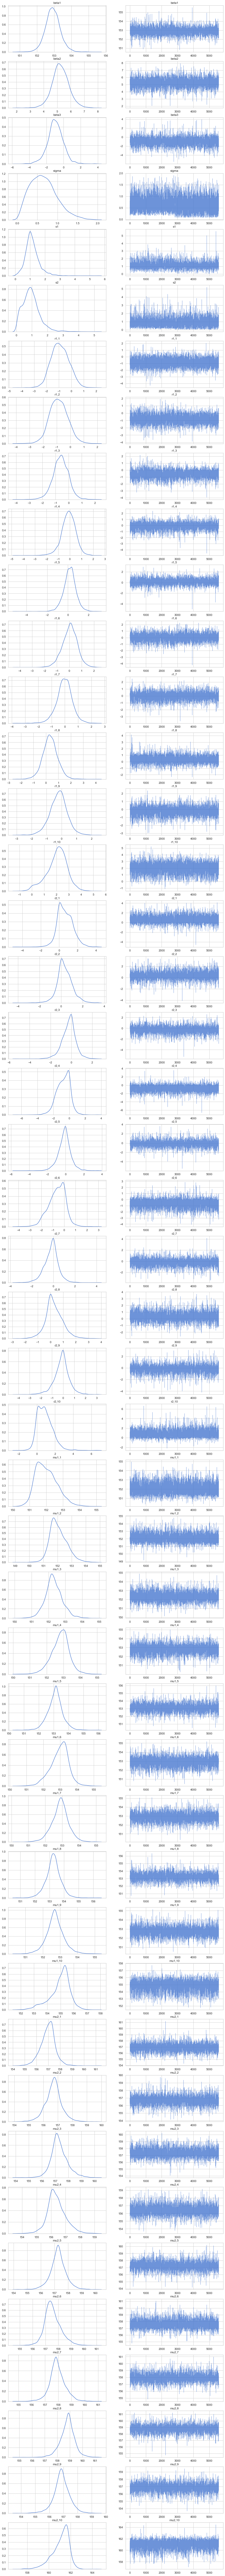

In [17]:
la  = fit_model2.extract(permuted=True) #extract results
names = fit_model2.model_pars #get  parameters names
n_param = np.sum([1 if len(x) == 0 else np.prod(x) for x in fit_model2.par_dims])
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt=0
for name in names:
    temp_data = la[name]
    #r, mu
    if temp_data.ndim == 3:
        for i in range(temp_data.shape[1]):
            for j in range(temp_data.shape[2]):
                d = temp_data[:,i,j]
                sns.distplot(d, hist=False, ax=axes[cnt, 0])
                x = np.linspace(0, len(d)-1, len(d))
                sns.lineplot(x,d,alpha=0.8, lw=.5, ax=axes[cnt, 1])
                cnt += 1
    #s
    elif temp_data.ndim == 2:
        for i in range(temp_data.shape[1]):
            d = temp_data[:,i]
            sns.distplot(d, hist=False, ax=axes[cnt, 0])
            x = np.linspace(0, len(d)-1, len(d))
            sns.lineplot(x,d,alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    #Intercept
    else:
        sns.distplot(temp_data, hist=False, ax=axes[cnt, 0])
        x = np.linspace(0, len(temp_data)-1, len(temp_data))
        sns.lineplot(x, temp_data,alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1
        
name_list = []
for name in names:
    temp_data = la[name]
    if temp_data.ndim == 3:
        for i in range(temp_data.shape[1]):
            for j in range(temp_data.shape[2]):
                name_list.append("{}{},{}".format(name,i+1,j+1))
    elif temp_data.ndim == 2:
        for i in range(temp_data.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()

### Reproduction of the diagram

[Model 1]Probability of being greater than zero. : 2.892857142857143 %
[Model 2]Probability of being greater than zero. : 13.803571428571429 %


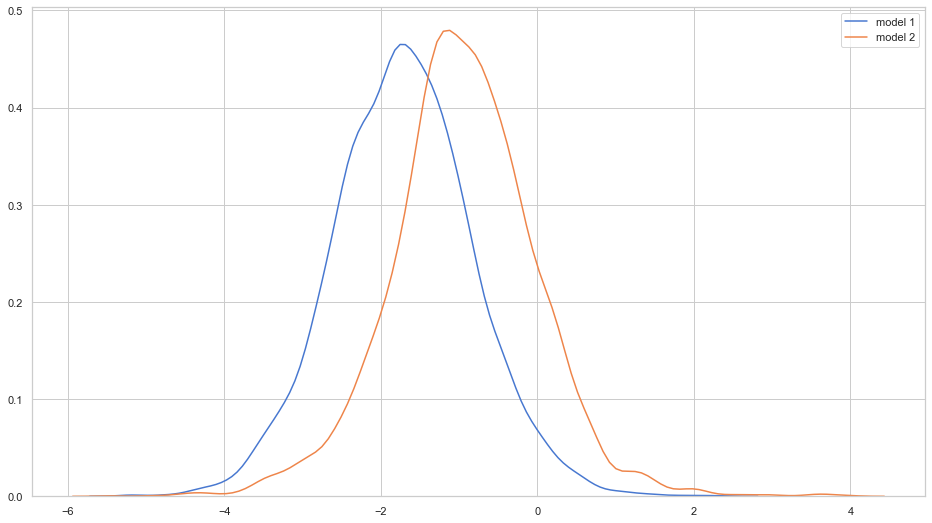

In [18]:
la_model1  = fit_model1.extract(permuted=True)
la_model2  = fit_model2.extract(permuted=True)

print("[Model 1]Probability of being greater than zero. :" , (len(np.where(la_model1["beta3"]>0)[0]) / len(la_model1["beta3"]))*100 , "%")
print("[Model 2]Probability of being greater than zero. :" , (len(np.where(la_model2["beta3"]>0)[0]) / len(la_model2["beta3"]))*100 , "%")
plt.figure(figsize=(16,9))
sns.distplot(la_model1["beta3"], hist=False, label="model 1")
sns.distplot(la_model2["beta3"], hist=False, label="model 2")
plt.show()

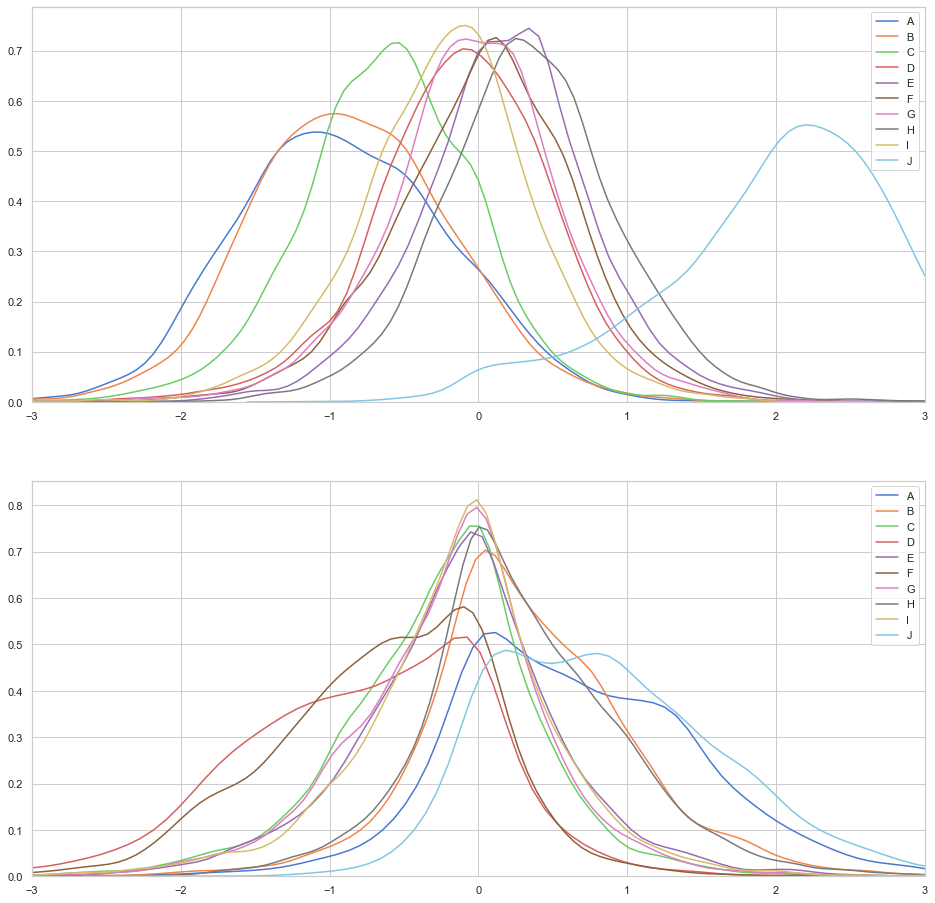

In [19]:
r1 = la_model2["r"][:,0,:]
r2 = la_model2["r"][:,1,:]

prefecture_name = ["A", "B", "C", "D", "E","F","G","H","I","J"]
plt.figure(figsize=(16,16))
plt.subplot(211)
for i in range(r1.shape[1]):
    sns.distplot(r1[:,i], hist=False, label=prefecture_name[i])
plt.xlim([-3,3])
plt.subplot(212)
for i in range(r2.shape[1]):
    sns.distplot(r2[:,i], hist=False, label=prefecture_name[i])
    plt.xlim([-3,3])